In [1]:
import json
import networkx as nx
import numpy as np
import math
from numpy.linalg import norm

In [2]:
def readJson(path,nodeType):
    G = []
    nodes = []
    f = open(path)
    graph = json.load(f, parse_int=str)
    count = 1
    for node in graph['storeNodes']:
        nodeId = nodeType + str(count)
        nodePos = np.array([int(node['posX']),int(node['posY'])])
        G.append([nodeId,nodePos])
        nodes.append([nodeId,node['storeName']])
        count += 1
    return (G,nodes)

In [3]:
sGraph, sNodes = readJson("./Jsons/S3.json","S")
print('sGraph')
print(sGraph)
cGraph, cNodes = readJson("./Jsons/C3.json","C")
print('cGraph')
print(cGraph)

sGraph
[['S1', array([7, 4])], ['S2', array([12,  4])], ['S3', array([17,  4])], ['S4', array([36,  9])], ['S5', array([36, 16])], ['S6', array([33, 25])], ['S7', array([21, 25])], ['S8', array([10, 25])], ['S9', array([ 3, 22])], ['S10', array([ 3, 15])], ['S11', array([3, 8])], ['S12', array([12, 15])], ['S13', array([19, 13])], ['S14', array([27, 13])], ['S15', array([27, 17])], ['S16', array([20, 17])]]
cGraph
[['C1', array([19,  7])], ['C2', array([ 7, 13])], ['C3', array([20, 21])], ['C4', array([32, 14])]]


In [4]:
def alignNodes(G):
    i = 0
    for nodeId_i, pos_i in G:
        i += 1
        for nodeId_j, pos_j in G[i:]:
            for axis in range(2):
                if(1 <= abs(pos_i[axis] - pos_j[axis]) < 2):
                    pos_i[axis] = pos_j[axis] = (pos_i[axis] + pos_j[axis])/2
    
    i = 0
    for nodeId_i, pos_i in G:
        i += 1
        for nodeId_j, pos_j in G[i:]:
            for axis in range(2):
                if(1 <= abs(pos_i[axis] - pos_j[axis]) < 2):
                    pos_i[axis] = pos_j[axis] = int((pos_i[axis] + pos_j[axis])//2)
    return G

In [5]:
storeNodes = alignNodes(sGraph)
print("storeNodes")
print(storeNodes)
corridorNodes = alignNodes(cGraph)
print("corridorNodes")
print(corridorNodes)

storeNodes
[['S1', array([7, 4])], ['S2', array([12,  4])], ['S3', array([17,  4])], ['S4', array([36,  8])], ['S5', array([36, 15])], ['S6', array([33, 25])], ['S7', array([19, 25])], ['S8', array([10, 25])], ['S9', array([ 3, 22])], ['S10', array([ 3, 15])], ['S11', array([3, 8])], ['S12', array([12, 15])], ['S13', array([19, 13])], ['S14', array([27, 13])], ['S15', array([27, 17])], ['S16', array([19, 17])]]
corridorNodes
[['C1', array([19,  7])], ['C2', array([ 7, 13])], ['C3', array([19, 21])], ['C4', array([32, 13])]]


In [6]:
def getCorridors(G):
    G = sorted(G,key=lambda x: x[1][0])
    Corners = []
    i = 0
    for nodeId_i, pos_i in G:
        i += 1
        for nodeId_j, pos_j in G[i:]:
            if(not(pos_i[0] == pos_j[0] or pos_i[1] == pos_j[1])):
                if(not([pos_i[0],pos_j[1]] in Corners)):
                    Corners.append([pos_i[0],pos_j[1]])
                else: 
                    Corners.pop(Corners.index([pos_i[0],pos_j[1]]))

                if(not([pos_j[0],pos_i[1]] in Corners)):
                    Corners.append([pos_j[0],pos_i[1]])
                else:
                    Corners.pop(Corners.index([pos_j[0],pos_i[1]]))
    corridorCorners = []
    count = 1
    for node in Corners:
        cId = "C" + str(count)
        corridorCorners.append([cId,np.array(node)])
        count += 1

    Corridors = []
    for i in range(len(Corners)):
            for j in range(i+1,len(Corners)):
                if(Corners[i][0]==Corners[j][0]):
                    Corridors.append([0,np.array(Corners[i]),np.array(Corners[j])])
                if(Corners[i][1]==Corners[j][1]):
                    Corridors.append([1,np.array(Corners[i]),np.array(Corners[j])])
    return corridorCorners, Corridors

In [7]:
corridorCorners, corridors= getCorridors(corridorNodes)
print('corridorCorners')
print(corridorCorners)
print('corridors')
print(corridors)

corridorCorners
[['C1', array([7, 7])], ['C2', array([ 7, 21])], ['C3', array([32,  7])], ['C4', array([32, 21])]]
corridors
[[0, array([7, 7]), array([ 7, 21])], [1, array([7, 7]), array([32,  7])], [1, array([ 7, 21]), array([32, 21])], [0, array([32,  7]), array([32, 21])]]


In [8]:
# d = norm(np.cross(p2-p1, p1-p3))/norm(p2-p1)
def getCorridorNodes(storeNodes,Corridors,CorridorNodes):
    for sId,storeNode in storeNodes:
        distance = [9999]
        newNode = np.copy(storeNode)            
        for [axis,p1,p2] in Corridors:
            d = norm(np.cross(p2-p1, p1-storeNode))/norm(p2-p1)
            if(distance[0] > d):
                distance = [d,axis,p1]
            if(d == 0):
                if(norm(p1-storeNode)>norm(p2-storeNode)):
                    newNode = np.copy(p2)
                else:
                    newNode = np.copy(p1)
                break
        newNode[distance[1]] = distance[2][distance[1]]
        flag = 1
        for cId ,cnode in CorridorNodes:
            if(np.array_equal(newNode,cnode)):
                flag = 0
                break
        if(flag):
            cId = "C" + str(len(CorridorNodes) + 1)
            CorridorNodes.append([cId,newNode])
    return CorridorNodes

In [9]:
corridorNodes = corridorCorners.copy()
corridorNodes = getCorridorNodes(storeNodes,corridors,corridorNodes)
print(corridorNodes)

[['C1', array([7, 7])], ['C2', array([ 7, 21])], ['C3', array([32,  7])], ['C4', array([32, 21])], ['C5', array([12,  7])], ['C6', array([17,  7])], ['C7', array([36,  7])], ['C8', array([32, 15])], ['C9', array([32, 25])], ['C10', array([19, 21])], ['C11', array([ 7, 25])], ['C12', array([ 3, 21])], ['C13', array([ 7, 15])], ['C14', array([3, 7])], ['C15', array([19,  7])], ['C16', array([32, 13])], ['C17', array([27, 21])]]


In [10]:
def connectSNodes(corridorNodes,storeNodes):
    edges = []
    for sId, p1 in storeNodes:
        distance = [9999]
        for cId, p2 in corridorNodes:
            if((p1 == p2).any()):
                d = int(norm(p2-p1))
                if(distance[-1]>d):
                    distance = [sId,cId,p1,p2,d]
        edges.append(distance)
    return edges

In [11]:
sEdges = connectSNodes(corridorNodes,storeNodes)
for edge in sEdges:
    print(edge)

['S1', 'C1', array([7, 4]), array([7, 7]), 3]
['S2', 'C5', array([12,  4]), array([12,  7]), 3]
['S3', 'C6', array([17,  4]), array([17,  7]), 3]
['S4', 'C7', array([36,  8]), array([36,  7]), 1]
['S5', 'C8', array([36, 15]), array([32, 15]), 4]
['S6', 'C9', array([33, 25]), array([32, 25]), 1]
['S7', 'C10', array([19, 25]), array([19, 21]), 4]
['S8', 'C11', array([10, 25]), array([ 7, 25]), 3]
['S9', 'C12', array([ 3, 22]), array([ 3, 21]), 1]
['S10', 'C13', array([ 3, 15]), array([ 7, 15]), 4]
['S11', 'C14', array([3, 8]), array([3, 7]), 1]
['S12', 'C13', array([12, 15]), array([ 7, 15]), 5]
['S13', 'C15', array([19, 13]), array([19,  7]), 6]
['S14', 'C16', array([27, 13]), array([32, 13]), 5]
['S15', 'C17', array([27, 17]), array([27, 21]), 4]
['S16', 'C10', array([19, 17]), array([19, 21]), 4]


In [12]:
def connectCNodes(corridorNodes):
    edges = []
    i = 0
    for cId_i, p1 in corridorNodes:
        # i += 1
        distance = []
        for cId_j, p2 in corridorNodes:
            if((p1 == p2).any()):
                d = int(norm(p2-p1))
                distance.append([cId_i,cId_j,p1,p2,d])
        distance = sorted(distance,key=lambda x: x[-1])
        try:
            edges.append(distance[1])
            edges.append(distance[2])
        except:
            pass
    return edges

In [13]:
cEdges = connectCNodes(corridorNodes)
for edge in cEdges:
    print(edge)

['C1', 'C14', array([7, 7]), array([3, 7]), 4]
['C1', 'C5', array([7, 7]), array([12,  7]), 5]
['C2', 'C11', array([ 7, 21]), array([ 7, 25]), 4]
['C2', 'C12', array([ 7, 21]), array([ 3, 21]), 4]
['C3', 'C7', array([32,  7]), array([36,  7]), 4]
['C3', 'C16', array([32,  7]), array([32, 13]), 6]
['C4', 'C9', array([32, 21]), array([32, 25]), 4]
['C4', 'C17', array([32, 21]), array([27, 21]), 5]
['C5', 'C1', array([12,  7]), array([7, 7]), 5]
['C5', 'C6', array([12,  7]), array([17,  7]), 5]
['C6', 'C15', array([17,  7]), array([19,  7]), 2]
['C6', 'C5', array([17,  7]), array([12,  7]), 5]
['C7', 'C3', array([36,  7]), array([32,  7]), 4]
['C7', 'C15', array([36,  7]), array([19,  7]), 17]
['C8', 'C16', array([32, 15]), array([32, 13]), 2]
['C8', 'C4', array([32, 15]), array([32, 21]), 6]
['C9', 'C4', array([32, 25]), array([32, 21]), 4]
['C9', 'C8', array([32, 25]), array([32, 15]), 10]
['C10', 'C17', array([19, 21]), array([27, 21]), 8]
['C10', 'C2', array([19, 21]), array([ 7, 21])

In [14]:
print('allNodes')
allNodes = storeNodes.copy()
allNodes += corridorNodes
# for node in allNodes:
#     print(node)

print('allEdges')
allEdges = sEdges.copy()
allEdges += cEdges
# for edge in allEdges:
#     print(edge)

allNodes
allEdges


In [15]:
def createGraph(nodes,edges):
    G = nx.Graph()
    for [id, pos] in nodes:
        G.add_node(id,
                   storeName = id,
                   position = (pos[0],-pos[1]))
    
    for [id1, id2, p1, p2, d]  in edges:
        G.add_edge(id1,id2,weight = d)
    return G
def showGraph(G):
    pos = {}
    for node in G.nodes(data = True):
        print(node)
        pos[node[0]] = [int(p) for p in node[1]['position'][0:2]]
    nx.draw_networkx(G, pos = pos)

In [16]:
# G = createGraph(storeNodes,sEdges)
# showGraph(G)

('C1', {'storeName': 'C1', 'position': (7, -7)})
('C2', {'storeName': 'C2', 'position': (7, -21)})
('C3', {'storeName': 'C3', 'position': (32, -7)})
('C4', {'storeName': 'C4', 'position': (32, -21)})
('C5', {'storeName': 'C5', 'position': (12, -7)})
('C6', {'storeName': 'C6', 'position': (17, -7)})
('C7', {'storeName': 'C7', 'position': (36, -7)})
('C8', {'storeName': 'C8', 'position': (32, -15)})
('C9', {'storeName': 'C9', 'position': (32, -25)})
('C10', {'storeName': 'C10', 'position': (19, -21)})
('C11', {'storeName': 'C11', 'position': (7, -25)})
('C12', {'storeName': 'C12', 'position': (3, -21)})
('C13', {'storeName': 'C13', 'position': (7, -15)})
('C14', {'storeName': 'C14', 'position': (3, -7)})
('C15', {'storeName': 'C15', 'position': (19, -7)})
('C16', {'storeName': 'C16', 'position': (32, -13)})
('C17', {'storeName': 'C17', 'position': (27, -21)})


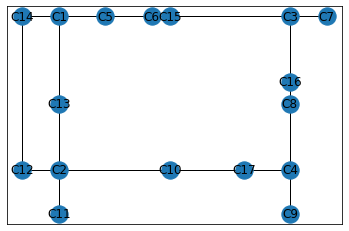

In [17]:
G = createGraph(corridorNodes,cEdges)
showGraph(G)

('S1', {'storeName': 'S1', 'position': (7, -4)})
('S2', {'storeName': 'S2', 'position': (12, -4)})
('S3', {'storeName': 'S3', 'position': (17, -4)})
('S4', {'storeName': 'S4', 'position': (36, -8)})
('S5', {'storeName': 'S5', 'position': (36, -15)})
('S6', {'storeName': 'S6', 'position': (33, -25)})
('S7', {'storeName': 'S7', 'position': (19, -25)})
('S8', {'storeName': 'S8', 'position': (10, -25)})
('S9', {'storeName': 'S9', 'position': (3, -22)})
('S10', {'storeName': 'S10', 'position': (3, -15)})
('S11', {'storeName': 'S11', 'position': (3, -8)})
('S12', {'storeName': 'S12', 'position': (12, -15)})
('S13', {'storeName': 'S13', 'position': (19, -13)})
('S14', {'storeName': 'S14', 'position': (27, -13)})
('S15', {'storeName': 'S15', 'position': (27, -17)})
('S16', {'storeName': 'S16', 'position': (19, -17)})
('C1', {'storeName': 'C1', 'position': (7, -7)})
('C2', {'storeName': 'C2', 'position': (7, -21)})
('C3', {'storeName': 'C3', 'position': (32, -7)})
('C4', {'storeName': 'C4', 'po

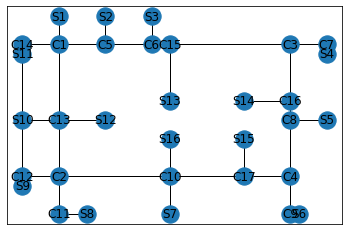

In [18]:
G = createGraph(allNodes,allEdges)
showGraph(G)